<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/data_wrangling/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

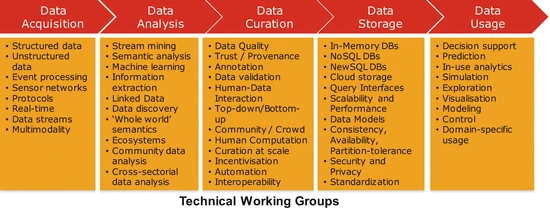

# The Project

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Analysis to be performed
  1. Solution
1. Analytical context
  1. Requirements
  1. The Dataset
  1. Data set structure
  1. Data dimensions
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Github
  1. External data (API)
  1. Backup
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values
  1. Transformation of data types
  1. Categorical variable labeling
  1. Attribute engineering
  1. Outliers
  1. z-score method
  1. IQR method
  1. Secondary data set (optional)
  1. Save files
1. Exploratory Data Analysis (EDA)
  1. EDA Conclusions
1. Feature Selection
  1. Correlation matrix
  1. Stepwise
1. Model training
  1. Split the dataframe
1. Massive model training
  1. Models: Configuration
  1. Comparison
  1. ROC Raven
  1. Bias and Variance
1. Final project results
1. Conclusions and final recommendations
1. References
1. Change log

# Analytical context

## The dataset

This spreadsheet shows historical alternative fueling station counts by state on an annual basis since December 2007. This data is based on the number of public and private (non-residential) stations in the Alternative Fuels Data Center (AFDC) Alternative Fueling Station Locator (https://afdc.energy.gov/stations/) near the end of December each year. You can see total fuel type counts in the "Total" row at the bottom of each tab.

Note that changes in total counts represent both stations that opened and went out of service. For example, if the number of stations increased from 200 to 210 in one year, it could have been that 15 stations opened and 5 stations went out of service.

Please note the following regarding counts for the electric vehicle (EV) charging station data:
 - **Starting in 2011**, EV charging was counted by the outlet rather than by the geographical location.
 - **Beginning in 2014**, the historical data for EV charging includes both the number of EV charging station locations and the number of outlets at each location.  
 - **Starting in 2020**, EV charging data is provided by charger level.

Please note the following regarding counts for propane station data:
 - Starting in 2020, propane station data is broken down by primary or secondary designations.

 Link to original data set: https://www.kaggle.com/datasets/saketpradhan/electric-and-alternative-fuel-charging-stations

## Libraries used

In [1]:
# Visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Otros
import datetime
from datetime import datetime, timedelta
# Configura la zona horaria local
import pytz

# Configuración adicional
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

# File import
import requests
from openpyxl import load_workbook
from io import BytesIO

## Setting

In [2]:
# Configura la zona horaria local
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

## Functions

In [ ]:
def corregir_columnas(df_temp: pd.DataFrame, column_mapping):
    total_columnas = len(df_temp.columns)
    columns_ok = 1

    for i in range(total_columnas):
        if df_temp.columns[i] in column_mapping[i]:
            continue
        else:
            print(f"columna incorrecta: {df_temp.columns[i]}")

            # Obtener el nombre correcto de la columna del diccionario
            nombre_correcto = column_mapping.get(i)

            if nombre_correcto:
                df_temp.rename(columns={df_temp.columns[i]: nombre_correcto}, inplace=True)
                print("Corregida!")
                columns_ok = 0
            else:
                print("No hay mapeo encontrado.")

    if columns_ok:
          columns_ok = 1
          print("Columnas OK.")

    return

In [3]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    Esta función muestra la fecha y hora local cada vez que es invocada.
    :param local_timezone: La zona horaria local deseada (por defecto, 'America/Argentina/Buenos_Aires').
    :return: La fecha y hora local en el formato especificado.
    '''
    try:
        # Obtiene la hora local actual en UTC
        utc_now = datetime.utcnow()

        # Convierte la hora actual a la hora local
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Formato de salida para la fecha y hora local
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Retorna la fecha y hora local formateada
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # En caso de error, imprime el error y retorna None
        print("Error al obtener la fecha y hora local:", str(e))
        return None

In [4]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [5]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

In [6]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Almacena físicamente los datos obtenidos en un archivo CSV.
    :param nombre_archivo: El nombre base del archivo CSV.
    :param df: El DataFrame que se desea guardar en el archivo CSV.
    '''
    try:
        # Obtiene la fecha y hora actual para agregarla al nombre del archivo
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Especifica la ruta y el nombre del archivo CSV
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Guarda el DataFrame en un archivo CSV sin incluir el índice
        df.to_csv(ruta_archivo_csv, index=False)

        # Imprime la fecha y hora de guardado y la ruta del archivo
        print("Fecha y hora:", fecha_y_hora_actual)
        print(f"Los datos se han guardado en el archivo CSV: {ruta_archivo_csv}")

    except Exception as error:
        # Maneja cualquier error que pueda ocurrir durante el proceso de guardado
        print(f"Ocurrió un error al guardar los datos en el archivo CSV: {error}")

In [7]:
def validar_rango_datos(df, column_name, min_value, max_value):
    """
    Función para verificar si hay valores fuera de un rango especificado en una columna de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna que se va a verificar.
    - min_value: Valor mínimo permitido en la columna.
    - max_value: Valor máximo permitido en la columna.

    Retorna:
    - filtered_values: DataFrame que contiene las filas con valores fuera del rango especificado.
    """
    # Filtrar los valores que están fuera del rango especificado
    filtered_values = df[(df[column_name] < min_value) | (df[column_name] > max_value)]

    # Verificar si no hay errores
    if filtered_values.empty:
        print('Esta característica no presenta errores')
        return None
    else:
        print('Se detectaron errores:')
        return filtered_values

In [8]:
def calcular_porcentage(df: pd.DataFrame, column_name: str):
    """
    Calcula el porcentaje de cada valor único en una columna de un DataFrame.

    Parámetros:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column_name (str): El nombre de la columna para la cual se calcularán los porcentajes.

    Retorna:
    pandas.Series: Una serie que contiene los porcentajes de cada valor único en la columna.
    """
    # Verificar si la columna existe en el DataFrame
    if column_name not in df.columns:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
        return None

    # Obtener recuentos de valores únicos en la columna
    value_counts = df[column_name].value_counts()

    # Calcular los porcentajes
    percentages = (value_counts / len(df[column_name])) * 100

    # Asignar un nombre al índice para mayor claridad
    percentages = percentages.rename_axis(column_name)

    return percentages

# Data acquisition

## Github

## Read the charging stations csv file

In [45]:
try:
    df_stations = pd.read_csv('https://raw.githubusercontent.com/omanofx/portfolio/main/data_wrangling/electric_and_alternative_fuel_charging_stations.csv', sep =",")
    print("CSV file has been uploaded successfully.")

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)

print(fecha_hora_local())

CSV file has been uploaded successfully.
2024-04-17 10:29:12


## Read the historical excel file

In [46]:
# URL del archivo .xlsx en GitHub
url = 'https://github.com/omanofx/portfolio/raw/main/data_wrangling/historical_station_counts_by_state_2007_2021.xlsx'

try:
    # Realizar la solicitud GET al archivo en GitHub
    respuesta = requests.get(url)

    # Verificar si la solicitud fue exitosa (código de estado 200)
    if respuesta.status_code == 200:
        # Leer el contenido del archivo .xlsx en un objeto BytesIO
        contenido_xlsx = BytesIO(respuesta.content)

        # Cargar el archivo .xlsx desde el objeto BytesIO
        libro_trabajo = load_workbook(contenido_xlsx, data_only=True)

        # Seleccionar la hoja de trabajo (worksheet) que deseas leer
        hoja = libro_trabajo.active

        print("File read successfully.")

        # Cerrar el archivo xlsx después de usarlo
        libro_trabajo.close()
    else:
        print("Could not get the .xlsx file from GitHub. Status code:", respuesta.status_code)

except Exception as e:
    print("An error occurred:", e)

print(fecha_hora_local())

File read successfully.
2024-04-17 10:29:25


Revision de datos

In [47]:
print("The original sheets:")
print(libro_trabajo.get_sheet_names())

The original sheets:
['About the Data', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']


In [48]:
# Get the worksheet object for the sheet named "About the Data"
worksheet = libro_trabajo.get_sheet_by_name("About the Data")

# Remove the worksheet
libro_trabajo.remove_sheet(worksheet)

#libro_trabajo.remove_sheet(worksheet)
print(f"These are the sheets available now in the file: \n", libro_trabajo.get_sheet_names())

These are the sheets available now in the file: 
 ['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']


In [13]:
'''
df_years = pd.DataFrame()
sheet_name = 2007

# Leer cada hoja del libro de trabajo
for sheet_name in libro_trabajo.sheetnames:
    sheet = libro_trabajo[sheet_name]
    print(f"Reading sheet: {sheet_name}")

    df = pd.read_excel(libro_trabajo, sheet_name = sheet_name, engine='openpyxl', header= 1, )
    df['year'] = int(sheet_name)  # Asignar el año correspondiente a la columna 'year' en df

    df_years = pd.concat([df_years, df], ignore_index=True)

#print(df_years.head())
'''

'\ndf_years = pd.DataFrame()\nsheet_name = 2007\n\n# Leer cada hoja del libro de trabajo\nfor sheet_name in libro_trabajo.sheetnames:\n    sheet = libro_trabajo[sheet_name]\n    print(f"Reading sheet: {sheet_name}")\n\n    df = pd.read_excel(libro_trabajo, sheet_name = sheet_name, engine=\'openpyxl\', header= 1, )\n    df[\'year\'] = int(sheet_name)  # Asignar el año correspondiente a la columna \'year\' en df\n\n    df_years = pd.concat([df_years, df], ignore_index=True)\n\n#print(df_years.head())\n'

## Process the historical excel file

Take the data from each sheet.

In [49]:
# Crear un DataFrame vacío
df_hojas = pd.DataFrame()

# Especifica la ruta de tu archivo Excel
archivo_excel = url

# Lee el archivo Excel
excel_file = pd.ExcelFile(archivo_excel)

# Obtiene los nombres de las hojas en el archivo Excel
hojas = excel_file.sheet_names

# Elimina la primera hoja
hojas.remove("About the Data")

In [50]:
# Algunas hojas tienen el nombre mal, utiliza una lista de validación
column_mapping = {
    0: 'State',
    1: 'Biodiesel',
    2: 'CNG',
    3: 'E85',
    4: 'Electric',
    5: 'Hydrogen',
    6: 'LNG',
    7: 'Propane',
    8: 'Total'
}

In [135]:
# BORRAR
hojas.clear()

# verde
hojas.append("2007")
'''
hojas.append("2008")
hojas.append("2009")
hojas.append("2010")
hojas.append("2011")
hojas.append("2012")
hojas.append("2013")

# amarillo
hojas.append("2014")
hojas.append("2015")
hojas.append("2016")
hojas.append("2017")
hojas.append("2018")
hojas.append("2019")
'''
# rojo
hojas.append("2020")
hojas.append("2021")


In [145]:
hoja ='2019'
df_hojas = pd.read_excel(archivo_excel, sheet_name = hoja, header = 1)

# Validar nombre de columnas
corregir_columnas(df_hojas, column_mapping)

# Eliminar registros con todas las columnas NaN
df_hojas = df_hojas.dropna(how='all')

# elimina los registro cuando las columnas 'State' y 'Total' sean NaN
df_hojas = df_hojas.dropna(subset=['State', 'Total'])
df_hojas.drop(df_hojas[df_hojas['State'] == 'Total'].index, inplace=True)

# Agregar una nueva columna 'Year' con el nombre de la hoja
df_hojas['Year'] = int(hoja)

df_hojas = df_hojas.replace('/', '|', regex=True)
df_hojas = df_hojas.replace(',', '', regex=True)
df_hojas

Columnas OK.


,State,Biodiesel,CNG,E85,Electric,Hydrogen,LNG,Propane,Total,Year
0,Alabama,10.0,27.0,34.0,195 | 506,0.0,2.0,72.0,651.0,2019
2,Alaska,0.0,1.0,0.0,19 | 34,0.0,0.0,5.0,40.0,2019
4,Arizona,78.0,30.0,22.0,522 | 1476,1.0,8.0,75.0,1690.0,2019
6,Arkansas,3.0,16.0,47.0,98 | 290,0.0,1.0,37.0,394.0,2019
8,California,29.0,321.0,195.0,6435 | 27128,48.0,44.0,273.0,28038.0,2019
10,Colorado,8.0,35.0,84.0,861 | 2516,1.0,1.0,52.0,2697.0,2019
12,Connecticut,2.0,17.0,3.0,422 | 1048,2.0,0.0,21.0,1093.0,2019
14,Delaware,1.0,2.0,1.0,57 | 172,1.0,0.0,9.0,186.0,2019
16,District of Columbia,7.0,2.0,3.0,172 | 553,1.0,0.0,0.0,566.0,2019
18,Florida,10.0,61.0,88.0,1562 | 4562,0.0,3.0,134.0,4858.0,2019


In [ ]:
# Dividir los valores de 'Electric' en nuevas columnas
nuevas_columnas_electric = df_hojas['Electric'].str.split('|', expand=True)


nuevas_columnas_electric.columns = ['Electric_station', 'Electric_outlets']

# Concatenar las nuevas columnas al DataFrame original
df_hojas = pd.concat([df_hojas, nuevas_columnas_electric], axis=1)

df_hojas

In [113]:
# Lista para almacenar los DF procesados
list_of_df = []

try:
    print(" --- Inicio de Loop --- ")
    for hoja in hojas:
        print("Procesando la hoja: " + hoja)
        print(50 * "-")
        # Bandera para indicar si los nombres de las columnas son correctos.
        columns_ok = 1
        df_hojas = pd.read_excel(archivo_excel, sheet_name = hoja, header = 1)

        total_columnas = df_hojas.shape[1]

        # Eliminar registros con todas las columnas NaN
        df_hojas = df_hojas.dropna(how='all')

        mascara = (df_hojas['State'].str.len() < 50) | (df_hojas['State'].isna())
        # Aplicamos la máscara para mantener solo las filas que cumplan con la condición
        df_hojas = df_hojas[mascara]

        # Validar y corregir el nombre de las columnas
        corregir_columnas(df_hojas, column_mapping)

        # Agregar una nueva columna 'Year' con el nombre de la hoja
        df_hojas['Year'] = int(hoja)

        # Agregar el DataFrame a la lista
        list_of_df.append(df_hojas)

        print()

    print(" --- Completado loop --- ")

    # Concatenar todos los DataFrames en la lista
    df_final = pd.concat(list_of_df, ignore_index=True)

    print("Eliminando los comentarios")
    #df_final = df_final[df_final['State'].str.len() <= 50]

    print("Eliminando registro Total")
    df_final.drop(df_final[df_final['State'] == 'Total'].index, inplace=True)

    print("Reemplazar caracteres '/', ','" )
    df_final = df_final.replace('/', '|', regex=True)
    df_final = df_final.replace(',', '', regex=True)

    # Reindexar el DataFrame final
    print("Reindexando el DataFrame final")
    df_final.reset_index(drop=True, inplace=True)

    # Convertir columnas a tipo entero si es necesario
    #columnas_entero = ['Biodiesel', 'CNG', 'E85', 'Electric', 'Hydrogen', 'LNG', 'Propane', 'Total']
    #df_final[columnas_entero] = df_final[columnas_entero].astype(int)

    print(fecha_hora_local())
except Exception as e:
    print("An error occurred:", e)


 --- Inicio de Loop --- 
Procesando la hoja: 2007
--------------------------------------------------
Columnas OK.

Procesando la hoja: 2020
--------------------------------------------------
columna incorrecta: Electrica
Corregida!
columna incorrecta: Hydrogenb
Corregida!
columna incorrecta: Propanec
Corregida!

Procesando la hoja: 2021
--------------------------------------------------
columna incorrecta: Electrica
Corregida!
columna incorrecta: Hydrogenb
Corregida!
columna incorrecta: Propanec
Corregida!
columna incorrecta: Totald
Corregida!

 --- Completado loop --- 
Eliminando los comentarios
Eliminando registro Total
Reemplazar caracteres '/', ','
Reindexando el DataFrame final
2024-04-17 11:27:24


In [114]:
df_final

,State,Biodiesel,CNG,E85,Electric,Hydrogen,LNG,Propane,Total,Year
0,Alabama,13.0,3.0,3.0,0.0,0.0,0.0,52.0,71.0,2007
1,Alaska,0.0,1.0,0.0,0.0,0.0,0.0,10.0,11.0,2007
2,Arizona,10.0,37.0,13.0,12.0,1.0,3.0,58.0,134.0,2007
3,Arkansas,3.0,3.0,4.0,0.0,0.0,0.0,41.0,51.0,2007
4,California,39.0,186.0,6.0,367.0,23.0,29.0,206.0,856.0,2007
...,...,...,...,...,...,...,...,...,...,...
254,Wisconsin,4.0,43.0,261.0,474 | 949,0 | 0 | 0,1.0,17 | 35 | 52,1310.0,2021
255,NaN,NaN,NaN,NaN,80 | 687 | 182,NaN,NaN,NaN,NaN,2021
256,Wyoming,0.0,9.0,9.0,70 | 184,0 | 0 | 0,0.0,6 | 14 | 20,222.0,2021
257,NaN,NaN,NaN,NaN,6 | 101 | 77,NaN,NaN,NaN,NaN,2021


ESTE CODIGO FUNCIONA OK

In [ ]:
# Lista para almacenar los DF procesados
list_of_df = []

try:
    print(" --- Inicio de Loop --- ")
    for hoja in hojas:
        print("Procesando la hoja: " + hoja)
        print(50 * "-")
        # Bandera para indicar si los nombres de las columnas son correctos.
        columns_ok = 1
        df_hojas = pd.read_excel(archivo_excel, sheet_name = hoja, header = 1)

        total_columnas = df_hojas.shape[1]

        corregir_columnas(df_hojas, column_mapping)

        for i in range(total_columnas):
            if df_hojas.columns[i] in column_mapping[i]:
                #print(f"columna correcta: {df_hojas.columns[i]}")
                continue
            else:
                print(f"columna incorrecta: {df_hojas.columns[i]}")

                # Obtener el nombre correcto de la columna del diccionario
                nombre_correcto = column_mapping.get(i)

                if nombre_correcto:
                    df_hojas.rename(columns={df_hojas.columns[i]: nombre_correcto}, inplace=True)
                    print("Corregida!")
                    columns_ok = 0
                else:
                    print("No hay mapeo encontrado.")

        if columns_ok:
          columns_ok = 1
          print("Columnas OK.")
          #print(f"Total registros/columnas:", df_hojas.shape)

        # Eliminar registros con todas las columnas NaN
        #df_hojas = df_hojas.dropna(how='all')

        # Agregar una nueva columna 'Year' con el nombre de la hoja
        df_hojas['Year'] = int(hoja)

        # Agregar el DataFrame a la lista
        list_of_df.append(df_hojas)

        print()

    print(" --- Completado loop --- ")

    # Concatenar todos los DataFrames en la lista
    df_final = pd.concat(list_of_df, ignore_index=True)

    print("Eliminando los comentarios")
    df_final = df_final[df_final['State'].str.len() <= 50]

    print("Eliminando registro Total")
    df_final.drop(df_final[df_final['State'] == 'Total'].index, inplace=True)

    print("Reemplazar caracteres '/', ','" )
    df_final = df_final.replace('/', '|', regex=True)
    df_final = df_final.replace(',', '', regex=True)

    # Reindexar el DataFrame final
    print("Reindexando el DataFrame final")
    df_final.reset_index(drop=True, inplace=True)

    # Convertir columnas a tipo entero si es necesario
    #columnas_entero = ['Biodiesel', 'CNG', 'E85', 'Electric', 'Hydrogen', 'LNG', 'Propane', 'Total']
    #df_final[columnas_entero] = df_final[columnas_entero].astype(int)

    print(fecha_hora_local())
except Exception as e:
    print("An error occurred:", e)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 50)

In [61]:
df_final

,State,Biodiesel,CNG,E85,Electric,Hydrogen,LNG,Propane,Total,Year
0,Alabama,10.0,30.0,29.0,223 | 596,0 | 0 | 0,2.0,24 | 45 | 69,736.0,2020
1,Alaska,0.0,1.0,0.0,25 | 45,0 | 0 | 0,0.0,1 | 2 | 3,49.0,2020
2,Arizona,75.0,30.0,20.0,574 | 1778,0 | 1 | 1,7.0,28 | 50 | 78,1989.0,2020
3,Arkansas,3.0,15.0,50.0,112 | 350,0 | 0 | 0,1.0,9 | 27 | 36,455.0,2020
4,California,27.0,322.0,198.0,7671 | 34622,43 | 6 | 49,41.0,87 | 181 | 268,35527.0,2020
...,...,...,...,...,...,...,...,...,...,...
97,Virginia,7.0,23.0,64.0,1139 | 3301,0 | 1 | 1,1.0,36 | 49 | 85,3482.0,2021
98,Washington,25.0,24.0,14.0,1775 | 4328,0 | 1 | 1,1.0,52 | 26 | 78,4471.0,2021
99,West Virginia,1.0,2.0,38.0,111 | 307,0 | 0 | 0,0.0,5 | 12 | 17,365.0,2021
100,Wisconsin,4.0,43.0,261.0,474 | 949,0 | 0 | 0,1.0,17 | 35 | 52,1310.0,2021


In [54]:
df_final['Year'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011,
       2010, 2009, 2008, 2007])

In [55]:
df_final['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [56]:
analizar_dataframe(df_final, 0)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
State,object,765,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Biodiesel,float64,765,0,0.000000,,39,False,765.000000,13.760000,21.980000,0.000000,3.000000,6.000000,14.000000,157.000000
CNG,float64,765,0,0.000000,,36,False,765.000000,25.310000,43.090000,0.000000,3.000000,12.000000,27.000000,324.000000
E85,float64,765,0,0.000000,,71,False,765.000000,56.220000,78.410000,0.000000,4.000000,23.000000,79.000000,454.000000
Electric,object,765,0,0.000000,,134,False,nan,nan,nan,nan,nan,nan,nan,nan
Hydrogen,object,765,0,0.000000,,459,False,nan,nan,nan,nan,nan,nan,nan,nan
LNG,float64,765,0,0.000000,,484,False,765.000000,1.700000,5.860000,0.000000,0.000000,0.000000,1.000000,47.000000
Propane,object,765,0,0.000000,,13,False,nan,nan,nan,nan,nan,nan,nan,nan
Total,float64,765,0,0.000000,,0,False,765.000000,918.960000,2687.960000,6.000000,110.000000,272.000000,892.000000,42193.000000
Year,int64,765,0,0.000000,,0,False,765.000000,2014.000000,4.320000,2007.000000,2010.000000,2014.000000,2018.000000,2021.000000


In [20]:
'''
total_columnas = df_hojas.shape[1]

for i in range(total_columnas):
    print(i)
    if df_hojas.columns[i] in column_mapping[i]:
        print(f"columna correcta: {df_hojas.columns[i]}")
    else:
        print(f"columna incorrecta: {df_hojas.columns[i]}")

        # Obtener el nombre correcto de la columna del diccionario column_mapping
        nombre_correcto = column_mapping.get(i)

        if nombre_correcto:
            df_hojas.rename(columns={df_hojas.columns[i]: nombre_correcto}, inplace=True)
            print("Corregida!")
        else:
            print("No hay mapeo encontrado.")
'''

'\ntotal_columnas = df_hojas.shape[1]\n\nfor i in range(total_columnas):\n    print(i)\n    if df_hojas.columns[i] in column_mapping[i]:\n        print(f"columna correcta: {df_hojas.columns[i]}")\n    else:\n        print(f"columna incorrecta: {df_hojas.columns[i]}")\n\n        # Obtener el nombre correcto de la columna del diccionario column_mapping\n        nombre_correcto = column_mapping.get(i)\n\n        if nombre_correcto:\n            df_hojas.rename(columns={df_hojas.columns[i]: nombre_correcto}, inplace=True)\n            print("Corregida!")\n        else:\n            print("No hay mapeo encontrado.")\n'

In [21]:
'''
# Procesa los registros según el semaforo de complejidad
      for index, row in df_hojas.iterrows():
        if row['State'] == 'Total':
          x = row['Year']
          print(x)

          if x in range(2020, 2022):
              print('RED')
              df_hojas.drop(df_hojas[df_hojas['State'] == 'Total'].index, inplace=True)
              df_hojas.drop(df_hojas[df_hojas['State'].isna()].index, inplace=True)

              df_hojas = df_hojas[df_hojas['State'].str.len() <= 50]

          elif x in range(2014, 2020):
            # Eliminar filas donde el valor de 'State' es 'Total'
            df_hojas.drop(df_hojas[df_hojas['State'] == 'Total'].index, inplace=True)

            # Eliminar filas donde el valor de 'State' es NaN
            df_hojas.drop(df_hojas[df_hojas['State'].isna()].index, inplace=True)

            print('YELLOW')

          elif x in range(2007, 2014):
              print('GREEN')
              df_hojas.drop(df_hojas[df_hojas['State'] == 'Total'].index, inplace=True)
              df_hojas.drop(df_hojas[df_hojas['State'].isna()].index, inplace=True)
          else:
              print("x está fuera de los rangos especificados")
'''

'\n# Procesa los registros según el semaforo de complejidad\n      for index, row in df_hojas.iterrows():\n        if row[\'State\'] == \'Total\':\n          x = row[\'Year\']\n          print(x)\n\n          if x in range(2020, 2022):\n              print(\'RED\')\n              df_hojas.drop(df_hojas[df_hojas[\'State\'] == \'Total\'].index, inplace=True)\n              df_hojas.drop(df_hojas[df_hojas[\'State\'].isna()].index, inplace=True)\n\n              df_hojas = df_hojas[df_hojas[\'State\'].str.len() <= 50]\n\n          elif x in range(2014, 2020):\n            # Eliminar filas donde el valor de \'State\' es \'Total\'\n            df_hojas.drop(df_hojas[df_hojas[\'State\'] == \'Total\'].index, inplace=True)\n\n            # Eliminar filas donde el valor de \'State\' es NaN\n            df_hojas.drop(df_hojas[df_hojas[\'State\'].isna()].index, inplace=True)\n\n            print(\'YELLOW\')\n\n          elif x in range(2007, 2014):\n              print(\'GREEN\')\n              df

## Reading the excel file

## Stations

In [57]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70406 entries, 0 to 70405
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fuel Type Code                    70406 non-null  object 
 1   Station Name                      70406 non-null  object 
 2   Street Address                    70405 non-null  object 
 3   Intersection Directions           4492 non-null   object 
 4   City                              70406 non-null  object 
 5   State                             70406 non-null  object 
 6   ZIP                               70405 non-null  object 
 7   Plus4                             0 non-null      float64
 8   Station Phone                     65204 non-null  object 
 9   Status Code                       70406 non-null  object 
 10  Expected Date                     1218 non-null   object 
 11  Groups With Access Code           70406 non-null  object 
 12  Acce

In [24]:
df_stations.head(5)

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
0,CNG,Spire - Montgomery Operations Center,2951 Chestnut St,NaN,Montgomery,AL,36107,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,MD,NaN,NaN,NaN
1,CNG,PS Energy - Atlanta,340 Whitehall St,"From I-7585 N, exit 91 to Central Ave, left on...",Atlanta,GA,30303,NaN,770-350-3000,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False
2,CNG,Metropolitan Atlanta Rapid Transit Authority,2424 Piedmont Rd NE,NaN,Atlanta,GA,30324,NaN,NaN,E,...,NaN,NaN,NaN,NaN,Q,3000,LD,NaN,NaN,NaN
3,CNG,United Parcel Service,270 Marvin Miller Dr,NaN,Atlanta,GA,30336,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,HD,NaN,NaN,NaN
4,CNG,Arkansas Oklahoma Gas Corp,2100 S Waldron Rd,NaN,Fort Smith,AR,72903,NaN,479-783-3188,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False


In [25]:
analizar_dataframe(df_stations, 90)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
Fuel Type Code,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Station Name,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Street Address,object,70405,1,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Intersection Directions,object,4492,65914,93.620000,BORRAR,0,True,nan,nan,nan,nan,nan,nan,nan,nan
City,object,70406,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
State,object,70406,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
ZIP,object,70405,1,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Plus4,float64,0,70406,100.000000,BORRAR,0,False,0.000000,nan,nan,nan,nan,nan,nan,nan
Station Phone,object,65204,5202,7.390000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Status Code,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan


In [26]:
df_stations.isna().sum().sort_values(ascending=False)

Plus4                           70406
BD Blends (French)              70404
EV Other Info                   70357
LNG On-Site Renewable Source    70344
Hydrogen Status Link            70323
                                ...  
ID                                  0
Updated At                          0
Station Name                        0
Country                             0
Fuel Type Code                      0
Length: 65, dtype: int64

In [27]:
df_stations['LNG Vehicle Class'].unique()

array([nan, 'HD'], dtype=object)

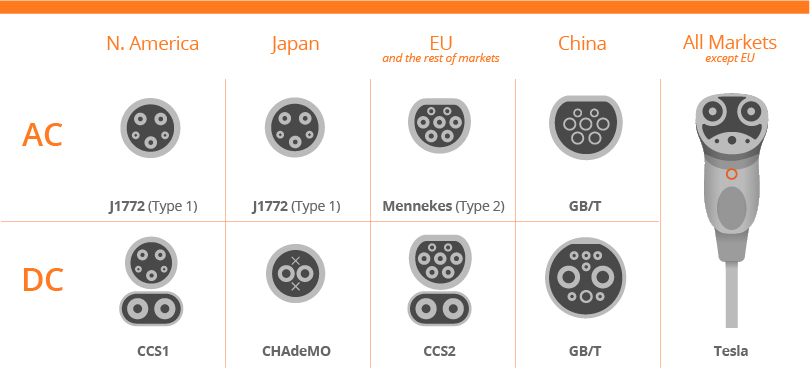

In [28]:
ev_connector_types = ["J1772",
                      "CHADEMO",
                      "COMBO",
                      "NEMA515",
                      "NEMA520",
                      "NEMA1450",
                      "TESLA"
                      ""
                      ]

In [29]:
# Completa los valores NaN con el valor 'unknown'
df_stations['EV Connector Types'].fillna('unknown', inplace=True)

In [30]:
df_stations['EV Connector Types'].value_counts()

EV Connector Types
J1772                               47190
unknown                              9716
CHADEMO J1772COMBO                   4357
TESLA                                3892
J1772 TESLA                          2834
CHADEMO J1772 J1772COMBO             1061
J1772COMBO                            519
CHADEMO J1772                         331
J1772 J1772COMBO                      134
J1772 NEMA515                         122
CHADEMO                               112
J1772 NEMA520                          95
J1772 NEMA1450                         23
CHADEMO J1772 J1772COMBO TESLA          6
CHADEMO J1772COMBO TESLA                2
CHADEMO J1772 NEMA520                   1
J1772COMBO TESLA                        1
J1772COMBO NEMA515                      1
CHADEMO J1772 J1772COMBO NEMA520        1
NEMA1450 TESLA                          1
CHADEMO NEMA520                         1
J1772 NEMA515 NEMA520                   1
J1772COMBO NEMA520                      1
CHADEMO J1772CO

In [31]:

df_stations['EV Connector Types'] = df_stations['EV Connector Types'].replace('J1772 J1772COMBO', 'J1772 COMBO')

In [32]:
# prompt: buscar 'tesla' en df_stations['EV Connector Types']

mask = df_stations['EV Connector Types'].str.contains('CHADEMO')
df_stations[mask]


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
156,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,CA,91352,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,CA,90012,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,CA,90803,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,ELEC,LADWP - EV Service Center,1630 N Main St,NaN,Los Angeles,CA,90012,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1588,ELEC,LADWP - Valley Center Admin Lot,14401 Saticoy St,At Van Nuys Blvd,Van Nuys,CA,91405,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70236,ELEC,ECG MSC DC 1,3299 Cooley Mesa Rd,NaN,Gypsum,CO,81637,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70275,ELEC,SNOPUD POWERED MUEVE3105 #2,2320 California St,NaN,Everett,WA,98201,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70276,ELEC,SNOPUD POWERED MUEVE3105 #1,2320 California St,NaN,Everett,WA,98201,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70395,ELEC,EVolveNY Salamanca,768 Broad Street,NaN,Salamanca,NY,14779,NaN,855-900-7584,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_stations['EV Connector Types'].unique()

array(['unknown', 'CHADEMO J1772 J1772COMBO', 'J1772', 'CHADEMO J1772',
       'J1772 NEMA520', 'J1772 NEMA515', 'J1772 TESLA',
       'CHADEMO J1772 NEMA515', 'J1772 COMBO', 'J1772 NEMA1450', 'TESLA',
       'CHADEMO', 'CHADEMO J1772 NEMA520 TESLA', 'CHADEMO J1772COMBO',
       'CHADEMO J1772 J1772COMBO TESLA', 'J1772COMBO',
       'CHADEMO J1772COMBO NEMA520', 'CHADEMO NEMA520',
       'J1772COMBO NEMA520', 'J1772 NEMA515 NEMA520',
       'CHADEMO J1772 NEMA520', 'NEMA1450 TESLA',
       'CHADEMO J1772 J1772COMBO NEMA520', 'CHADEMO J1772COMBO TESLA',
       'J1772COMBO NEMA515', 'J1772COMBO TESLA', 'NEMA1450'], dtype=object)

In [34]:
df_stations['EV Other Info'].unique()

array([nan, '1 SP Inductive', '3 SP Inductive', '2 Tesla Conductive',
       '1 Tesla Conductive', '1 Conductive 120V', '7 Conductive 120V',
       '1 LP Inductive', 'DCFC', 'L2'], dtype=object)

In [35]:
df_stations['EV Pricing'].unique()

array([nan, 'Free', 'Pay to Park', 'Free; parking fee',
       '$2 service fee; $0.45 per kWh', '$12 parking fee',
       '$7 per session', 'Free; parking is $8 per day.',
       '$0.30 per kWh; $0.45 per kWh from 4pm-9pm',
       '$1 per hour for first two hours; $3 per hour thereafter',
       'Free; $6.00 for parking day pass for non-permit holders',
       '$20 parking fee', '$9 parking fee',
       "Pay for garage' charging is free", '$1.50/hr', '$2 parking fee',
       '$0.75 per hour parking fee',
       '$1 per first and second half-hour parking fee; $1 per each additional hour parking fee',
       'Free; metered parking', 'Free; meter charge', '$10 per session',
       'Free for guests; $10 for non-guests',
       '$5 per session, customers pay up to $20 for leaving car connected after done charging',
       '$6 per session', '$1 per hour', '$0.25 per hour parking fee',
       '$1.50 per hour', 'Variable fee', '$0.13 per kWh',
       '$1 per hour parking fee; Maximum session t

In [36]:
df_stations['EV On-Site Renewable Source'].unique()

array([nan, 'SOLAR', 'WIND', 'HYDRO', 'NONE', 'WASTEWATER', 'LANDFILL'],
      dtype=object)

In [37]:
df_stations['BD Blends (French)'].unique()

array([nan, 'B100', 'B100, B50, B20'], dtype=object)

In [38]:
df_stations['Intersection Directions (French)'].unique()

array([nan, "A coté de l'office d'automobile",
       "A l'arrière du batiment avec une entrée très atroite",
       'SituÃ©e sur le cÃ´tÃ© ouest du parc',
       'Quai de chargement 2 -En arrière du batiment',
       "20 km à\xa0 l'ouest de Grand Falls-Windsor",
       "Située\xa0a l'intersection du stationnement, ou les bornes de recharge pour les VR se situent",
       'SituÃ©e sur le cÃ´tÃ© du bÃ¢timent dans la ruelle',
       'Coin arrière du bâtiment',
       'Stationnement principal - Coin sud-est du bâtiment',
       'SituÃ©e dans un nouveau projet sur la promenade Shepard, Ã©loignÃ© de tout bÃ¢timent. La promenade Shepard est Ã\xa0 votre droite lorsque que vous venez de la Trans Canada.',
       'Situé a la cité des enseignes communautaires près de la route dans un stationnement de cour de triage',
       "Par l'entrée principale", 'Sur la route 19A',
       'Entre la promenade Riverglen et la promenade Riveredge',
       "deux unitÃ©s Ã\xa0Â\xa0 l'extÃ©rieur, une unitÃ© Ã\xa0

## Feature Reduction

In [39]:
try:
  df_stations.drop(["Plus4",
                    "LNG Vehicle Class",
                    "Intersection Directions (French)",
                    "Access Days Time (French)",
                    "Groups With Access Code (French)",
                    "LNG On-Site Renewable Source",
                    "EV Level1 EVSE Num",
                    "EV Other Info",
                    "Hydrogen Status Link",
                    "BD Blends (French)",
                    "Hydrogen Is Retail",
                    "CNG Storage Capacity",
                    "Hydrogen Pressures",
                    "Hydrogen Standards",
                    "EV On-Site Renewable Source"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.


In [40]:
try:
  df_stations.drop(["EV DC Fast Count",
                    "Access Detail Code",
                    "E85 Blender Pump",
                    "Intersection Directions",
                    "EV Pricing (French)",
                    "LPG Primary",
                    "LPG Nozzle Types",
                    "NG Vehicle Class",
                    "CNG Vehicle Class",
                    "NG Fill Type Code",
                    "CNG Fill Type Code",
                    "CNG PSI",
                    "NG PSI",
                    "E85 Other Ethanol Blends",
                    "Expected Date",
                    "BD Blends",
                    "CNG Dispenser Num",
                    "Federal Agency Code",
                    "Federal Agency ID",
                    "Federal Agency Name",
                    "CNG On-Site Renewable Source",
                    "CNG Total Compression Capacity",
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.


In [41]:
try:
  df_stations.drop(["ID"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.
